# Building detection through Image Segmentation

Populate these constants before getting started

In [2]:
ROOTFOLDER = '/content/drive/MyDrive'
TRAINFOLDER = '/content/drive/MyDrive/Inria'
CSPROJECT = 'dl-final-349202' #'<your google cloud project>'    
BUCKET =    'dlgeo-storage-1' #'<your bucket name>'             
ASSETS =    'dl-final-349202' #'<path to your GEE assets>'      





Authenticate Earth Engine

In [3]:
# Import the GEE Python API
import ee
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=8TLW0QuqRto6FwRrUSWiS-xY3BkVJH4p4yqpK42uMWI&tc=9pjRlS6Ku34HN8PAzZljXDV4TSkxr0iu8_2gReY-ZVw&cc=1ntPCwejfMxdugPvaTv8cvH2uZW7ImWSHw2x4269-Lk

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgpL743njPxf41524If1RHwUJv3xY7tGFhScdX7lhNjnVBS54AhPlA

Successfully saved authorization token.


Authenticate Cloud

In [4]:

# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

In [5]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Just bulk batching imports
import os, sys, json, time, cv2, scipy, csv, subprocess
import tensorflow as tf
from osgeo import gdal,gdalconst
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import numpy as np
from PIL import Image
import matplotlib
from google.cloud import storage
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import *
import ipywidgets as widgets
from IPython.display import display
from geopy.geocoders import Nominatim

%matplotlib inline

tf.test.gpu_device_name()

'/device:GPU:0'

We install iPyLeaflet for the Widget functionality

In [7]:
from google.colab import output

!pip install -q ipyleaflet

# Enable the Widget manager
output.enable_custom_widget_manager()

# utilities
from ipyleaflet import (Map,DrawControl,TileLayer,
                        basemaps,basemap_to_tiles,
                        LayersControl,
                        MeasureControl,
                        FullScreenControl,
                        GeoJSON)

def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    return map_id["tile_fetcher"].url_format

def rgbLayer(image, lin2pc = True):
    rgbim = image.rename('r','g','b')
    mn = 0
    mx = 255
    if lin2pc:
#      two percent linear stretch
        ps = rgbim.reduceRegion(ee.Reducer.percentile([2,98]),scale=10,maxPixels=1e10).getInfo()
        mx = [ps['r_p98'],ps['g_p98'],ps['b_p98']]
        mn = [ps['r_p2'],ps['g_p2'],ps['b_p2']]
    return rgbim.visualize(min=mn,max=mx)

     |████████████████████████████████| 3.3 MB 4.2 MB/s 


# Visualizing Labels over real maps


-- This is some code I found to use google earth info instead of actual labels. Done by morty canty (referencing his projects here!)

In [ ]:
#Get Inria label
label = ee.Image('projects/ee-mortcanty/assets/inria/chicago1')
label_layer = TileLayer(url=GetTileLayerUrl(label.visualize(min=0,max=255)),name='Inria label')

# get matching NAIP image
naip2015 = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .filter(ee.Filter.date('2014-01-01', '2015-12-31')) \
                      .filterBounds(label.geometry()) \
                      .mosaic() \
                      .clip(label.geometry()) 
center = naip2015.geometry().centroid().coordinates().getInfo()[::-1]
image_layer = TileLayer(url=GetTileLayerUrl(rgbLayer(naip2015.select(['N','G','B']))),name='NAIP image')

# create ipyleaflet Map object
m = Map(center=center, zoom=15, layout={'height':'500px', 'width':'800px'}, controls = (LayersControl(position ='topright'),)) 

# overlay image and label
m.add_layer(image_layer)
m.add_layer(label_layer)

m

Map(center=[41.830884146664474, -87.71956058520085], controls=(LayersControl(options=['position'], position='t…

# UNet Model 
Sources:
- Morty Canty
- https://towardsdatascience.com/u-net-for-semantic-segmentation-on-unbalanced-aerial-imagery-3474fa1d3e56
- Original paper by Huang et Al



In [17]:

def conv2d(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters, 3, padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')])
def conv2dtranspose(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, 3, strides = 2, padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')])
# all MaxPooling layers have identical parameters    
def maxpooling2d():
    return tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2,padding = "same")

In [18]:
# UNet
def unet_model(num_channels = 4, image_size = 512):    
    inputs = tf.keras.layers.Input(shape = (image_size, image_size, num_channels))
    rescaled= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
#  encoder     
    conv11 = conv2d(64)(rescaled)
    conv12 = conv2d(64)(conv11)
    max_pool1 = maxpooling2d()(conv12)
    conv21 = conv2d(128)(max_pool1)
    conv22 = conv2d(128)(conv21)
    max_pool2 = maxpooling2d()(conv22)
    conv31 = conv2d(256)(max_pool2)
    conv32 = conv2d(256)(conv31)
    max_pool3 = maxpooling2d()(conv32)
    conv41 = conv2d(512)(max_pool3)
    conv42 = conv2d(512)(conv41)
    max_pool4 = maxpooling2d()(conv42)
    conv51 = conv2d(1024)(max_pool4)
    conv52 = conv2d(1024)(conv51)
#  decoder    
    uconv51 = conv2dtranspose(512)(conv52)
    merge_dec5 = tf.keras.layers.concatenate([conv42,uconv51], axis = 3)
    conv_dec_41 = conv2d(512)(merge_dec5)
    conv_dec_42 = conv2d(512)(conv_dec_41)
    uconv41 = conv2dtranspose(256)(conv_dec_42)
    merge_dec4 = tf.keras.layers.concatenate([conv32,uconv41], axis = 3)
    conv_dec_31 = conv2d(256)(merge_dec4)
    conv_dec_32 = conv2d(256)(conv_dec_31)
    uconv31 = conv2dtranspose(128)(conv_dec_32)
    merge_dec3 = tf.keras.layers.concatenate([conv22,uconv31], axis = 3)
    conv_dec_21 = conv2d(128)(merge_dec3)
    conv_dec_22 = conv2d(128)(conv_dec_21)
    uconv21 = conv2dtranspose(64)(conv_dec_22)
    merge_dec2 = tf.keras.layers.concatenate([conv12,uconv21], axis = 3)
    conv_dec_11 = conv2d(64)(merge_dec2)
    conv_dec_12 = conv2d(64)(conv_dec_11)
#  output    
    conv_dec_12 = conv2d(8)(conv_dec_12)
    output = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv_dec_12)
    return tf.keras.Model(inputs = inputs, outputs = output)

We could use this output for the poster if we wanted

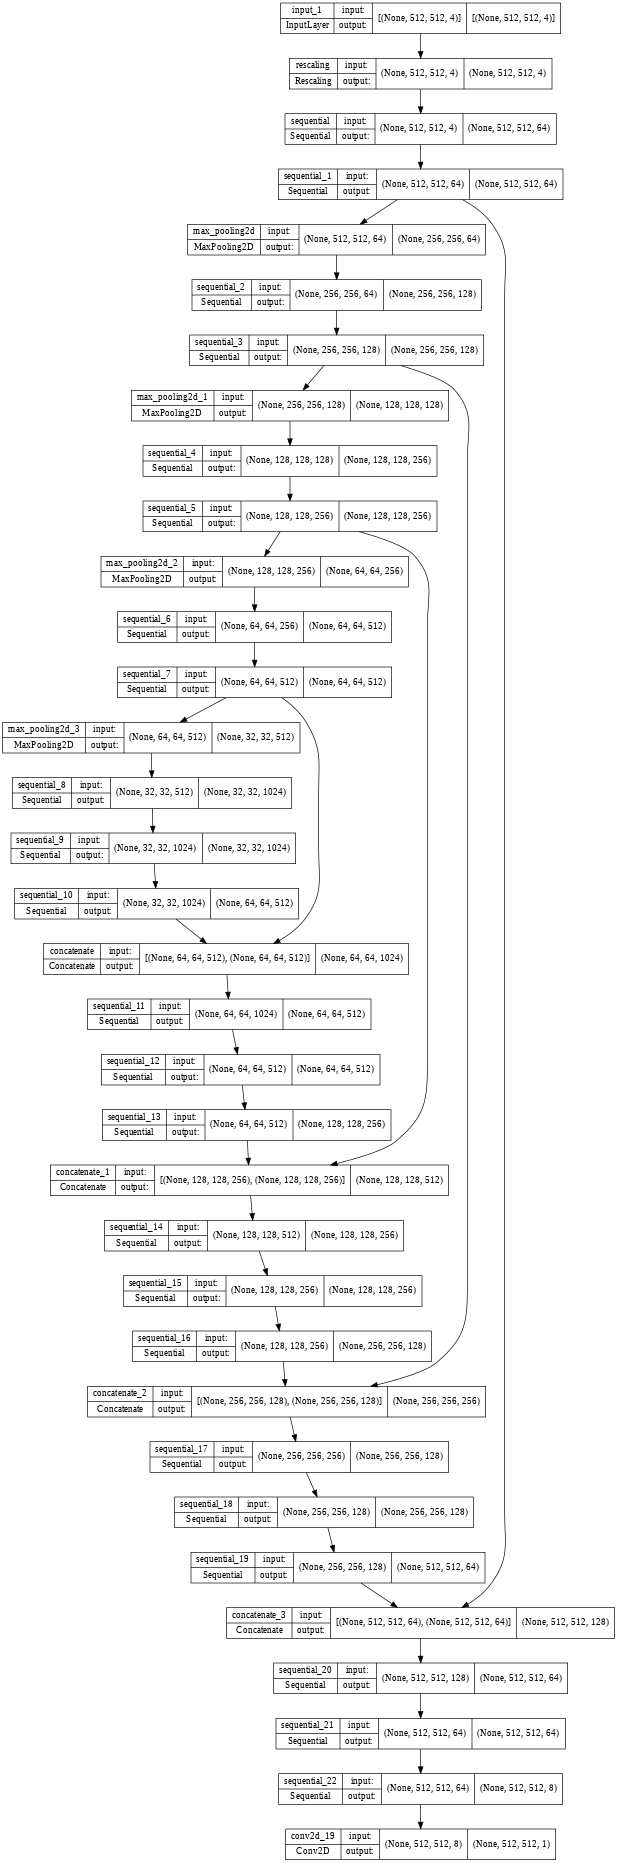

In [19]:
model = unet_model()
keras.utils.plot_model(model,'UNet.png',show_shapes=True,dpi=48) # Uncomment and it should build a nice model graph!

**Now** compile the model -- we should play with the params. I believe Huang et al use different #s and a custom loss fn

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

For now, lets just train over American cities (so that we can easily use Google Earth, NAICP data)

In [8]:
class MakeDataset():

    def _generator(path):
        with np.load(path) as data:
            examples = data['x'] 
            labels = data['y']
            for index, example in enumerate(examples):
                yield (example, np.array(labels[index], dtype = np.float32))

    def __new__(cls,path):
        return tf.data.Dataset.from_generator( 
            cls._generator, 
            output_signature = ( tf.TensorSpec(shape = (512, 512, 4), dtype = tf.uint8),
                                 tf.TensorSpec(shape = (512, 512, 1), dtype = tf.float32) ),
            args = (path,) 
                                             ).batch(4)

Visualize this first batch we generated. Kinda cool!!

In [9]:
train_dataset = MakeDataset(TRAINFOLDER+'/naip_images_train.npz')
test_dataset = MakeDataset(TRAINFOLDER+'/naip_images_test.npz')

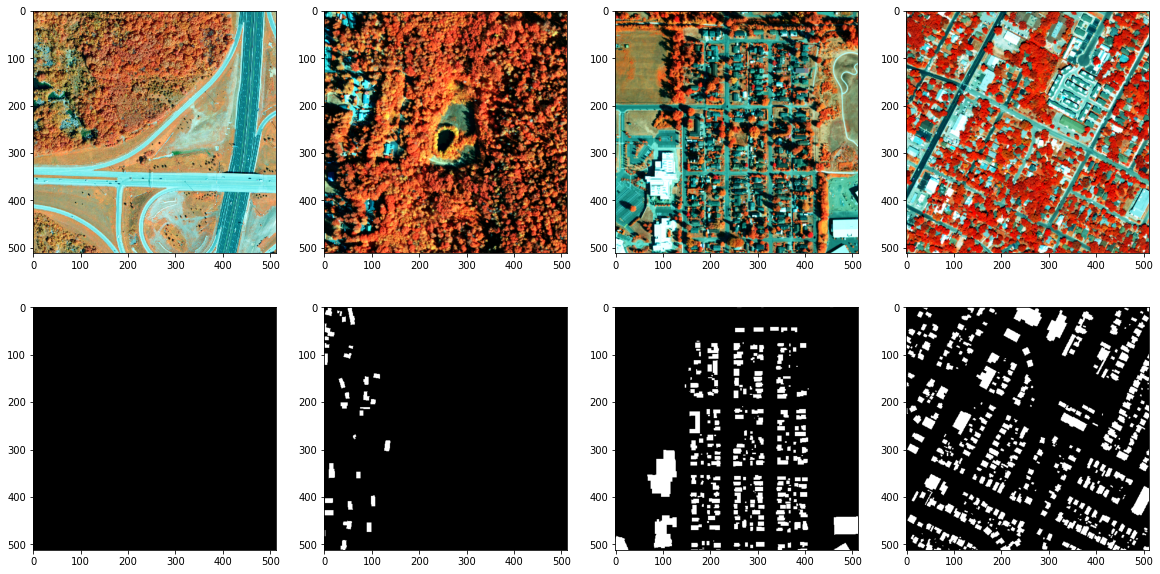

In [ ]:


train_examples, train_labels = next(train_dataset.as_numpy_iterator())
fig, ax = plt.subplots(2, 4, figsize = (20,10))
for i in range(4):
    ax[0,i].imshow(train_examples[i][:,:,[3,1,2]])
    ax[1,i].imshow(np.reshape(train_labels[i], (512,512)), cmap = plt.cm.gray)
plt.show()

# Training the Model


This takes a WHILE, so don't let your browser go to sleep. Maybe something like : 

```

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking, 60000)
```

In [ ]:

dest_model = '/unet_inria_model_1470.h5'

checkpoint = ModelCheckpoint(TRAINFOLDER+dest_model, monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger(TRAINFOLDER+'/training.log', append = True)

history = model.fit(train_dataset, epochs = 5, callbacks = [checkpoint,csv_logger], validation_data = test_dataset)

Epoch 1/5
    520/Unknown - 637s 1s/step - loss: 0.3100 - binary_accuracy: 0.8809

# Testing the Model

In [10]:
# Just run this if you don't want to retrain

model = keras.models.load_model(TRAINFOLDER+'/unet_inria_model_1470.h5')
model.evaluate(test_dataset)

135/135 [==============================] - 191s 1s/step - loss: 0.1692 - binary_accuracy: 0.9323


[0.16923941671848297, 0.9322589635848999]

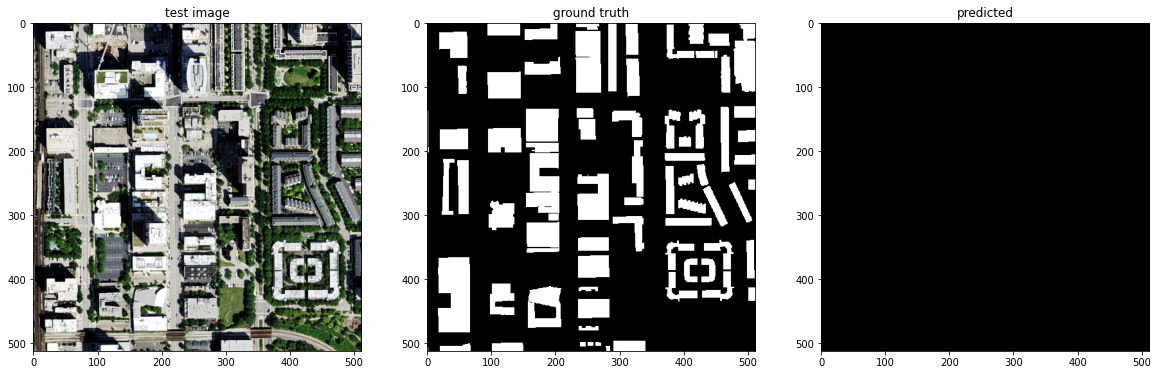

In [ ]:
k = 25   # batch (25)
i = 2   # test example (0)
t = 0.4 # probability threshold
testds = iter(test_dataset)
# skip to kth batch
for j in range(k): 
    test_example, test_label = next(testds) 
fig, ax = plt.subplots(1, 3, figsize = (20,10))
ax[0].imshow(test_example.numpy()[i][:,:,[0,1,2]])
label = np.reshape(test_label[i], (512,512))
ax[1].imshow(label,cmap = plt.cm.gray)
pred = model.predict(tf.reshape(test_example[i], (1,512,512,4)))
pred = np.reshape(np.where(pred > t, 1, 0), (512,512))
ax[2].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('ground truth')
ax[2].set_title('predicted')
plt.show()

# Inference on Providence:

Here, we should now collect images around Providence, etc



Some (needs to be adapted, does not work) webapp code:

In [11]:
#@title Tile-by-tile classification
def unetclassify(infile, modelpath, dims = None, threshold = 0.4): 

    def bytestretch(arr,rng=None):
    #  byte stretch image numpy array
        shp = arr.shape
        arr = arr.ravel()
        if rng is None:
            rng = [np.min(arr),np.max(arr)]
        tmp =  (arr-rng[0])*255.0/(rng[1]-rng[0])
        tmp = np.where(tmp<0,0,tmp)  
        tmp = np.where(tmp>255,255,tmp) 
        return np.asarray(np.reshape(tmp,shp),np.float32)
        
    def lin2pcstr(x):
    #  2% linear stretch
        x = bytestretch(x)
        hist,bin_edges = np.histogram(x,256,(0,256))
        cdf = hist.cumsum()
        lower = 0
        i = 0
        while cdf[i] < 0.02*cdf[-1]:
            lower += 1
            i += 1
        upper = 255
        i = 255
        while (cdf[i] > 0.98*cdf[-1]) and (upper>100):
            upper -= 1
            i -= 1
        fp = (bin_edges-lower)*255/(upper-lower)
        fp = np.where(bin_edges<=lower,0,fp)
        fp = np.where(bin_edges>=upper,255,fp)
        return np.interp(x,bin_edges,fp)      

    with w_out: 
        try:   
            model = keras.models.load_model(modelpath)
#          blob detector
            params = cv2.SimpleBlobDetector_Params() 
            params.minThreshold = 100
            params.maxThreshold = 256
            params.filterByCircularity = False
            params.filterByInertia = False
            params.filterByConvexity = False
            params.filterByColor = False
            params.filterByArea = True
            params.minArea = 20
            params.maxArea = 1e5
            detector = cv2.SimpleBlobDetector_create(params) 
            detector.empty()
#          read in rgbn image and do a linear 2% stretch           
            path = os.path.dirname(infile)
            basename = os.path.basename(infile)
            root, ext = os.path.splitext(basename)
            outfile = path + '/' + root + '_unet' + ext       
            start = time.time()           
            inDataset = gdal.Open(infile, GA_ReadOnly)
            cols = inDataset.RasterXSize
            rows = inDataset.RasterYSize     
            if dims:
                x0, y0, cols, rows = dims
            else:
                x0 = 0
                y0 = 0                   
            G = np.zeros((rows, cols, 4))                               
            for b in range(4):
                band = inDataset.GetRasterBand(b+1)
                G[:,:,b] = lin2pcstr(band.ReadAsArray(x0, y0, cols, rows))
#          classify in patches    
            xpatches = cols//512
            ypatches = rows//512       
            result = np.zeros((ypatches*512,xpatches*512))
            patch_num = 0
            num_patches = xpatches*ypatches          
            for iy in range(ypatches):
                w_out.clear_output()
                print('Predicting %i patches: %i completed ...'%(num_patches,patch_num))
                for ix in range(xpatches): 
                    patch_num += 1
                    patch = G[iy*512:(iy+1)*512,ix*512:(ix+1)*512,:]
                    patch = patch.reshape(1,512,512,4)
                    res = np.reshape(model.predict(patch)[0],(512,512))
                    result[iy*512:(iy+1)*512,ix*512:(ix+1)*512] = res
            result = np.where(result<threshold,0,255) 
            im = result.astype(np.uint8)
            keypoints = detector.detect(im)
            print('Done: Number of structures found: %i\nWriting to %s'%(len(keypoints),outfile))
#          write to drive    
            driver =  gdal.GetDriverByName('GTiff')
            outDataset = driver.Create(outfile,xpatches*512,ypatches*512,1,GDT_Float32)
            projection = inDataset.GetProjection()
            geotransform = inDataset.GetGeoTransform()
            if geotransform is not None:
                gt = list(geotransform)
                gt[0] = gt[0] + x0*gt[1]
                gt[3] = gt[3] + y0*gt[5]
                outDataset.SetGeoTransform(tuple(gt))
            if projection is not None:
                outDataset.SetProjection(projection)               
            outBand = outDataset.GetRasterBand(1)  
            outBand.WriteArray(result[:,:],0,0) 
            outBand.FlushCache() 
            inDataset = None
            outDataset = None    
            return outfile   
        except Exception as e:
            print('Error: %s'%e)         

In [12]:
#Widget interface
import ee
import os, json
import ipywidgets as widgets
from IPython.display import display
from ipyleaflet import (Map,DrawControl,TileLayer,
                        basemaps,basemap_to_tiles,
                        LayersControl,
                        MeasureControl,
                        FullScreenControl,
                        GeoJSON)
from geopy.geocoders import Nominatim

geolocator = Nominatim(timeout=10,user_agent='interface.ipynb')

def makefeature(data):
    ''' for exporting as CSV to Drive '''
    return ee.Feature(None, {'data': data})

def handle_draw(self, action, geo_json):
    global poly
    if action == 'created': 
        coords =  geo_json['geometry']['coordinates']
        print('Coordinates of box:')
        print(coords)
        poly = ee.Geometry.Polygon(coords)
        w_collect.disabled = False
        
dc = DrawControl(polyline={},circlemarker={})
dc.rectangle = {"shapeOptions": {"fillColor": "#0000ff","color": "#0000ff","fillOpacity": 0.1}}
dc.polygon = {"shapeOptions": {"fillColor": "#0000ff","color": "#0000ff","fillOpacity": 0.1}}

dc.on_draw(handle_draw)

w_out = widgets.Output(
    layout={'border': '1px solid black'}
)
w_startdate = widgets.Text(
    value='2017-01-01',
    placeholder=' ',
    description='Start date:',
    disabled=False
)
w_enddate = widgets.Text(
    value='2018-12-31',
    placeholder=' ',
    description='End date:',
    disabled=False
)
w_location = widgets.Text(
    value='Providence, Rhode Island',
    placeholder=' ',
    description='',
    disabled=False
)
w_exportname = widgets.Text(
    value='<filename>',
    placeholder=' ',
    disabled=False
)
w_modelpath = widgets.Text(
    value=TRAINFOLDER+'/unet_inria_model_1470.h5',
    placeholder=' ',
    layout = widgets.Layout(width='450px'),
    description='Model: ',
    disabled=False
)

w_goto = widgets.Button(description='GoTo')
w_clear = widgets.Button(description='Clear',disabled=False)
w_collect = widgets.Button(description="Collect",disabled=True)
w_export = widgets.Button(description='Export to Drive',disabled=True)
w_classify = widgets.Button(description='Classify',disabled=False)
w_show = widgets.Button(description='Show Buildings',disabled=False)
w_exp = widgets.HBox([w_export,w_exportname])

w_top = widgets.HBox([w_startdate,w_enddate])
w_mid1 = widgets.HBox([w_goto,w_location])
w_mid2 = widgets.HBox([w_collect,w_exp])
w_mid3 = widgets.HBox([w_classify,w_modelpath,w_show])
w_bot = widgets.HBox([w_clear,w_out])

box = widgets.VBox([w_top,w_mid1,w_mid2,w_mid3,w_bot])

def on_widget_change(b):
    pass

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"
    storage_client = storage.Client(project=CSPROJECT)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)    

def on_clear_button_clicked(b):
    with w_out:
        w_out.clear_output()
        print('Algorithm output')         
w_clear.on_click(on_clear_button_clicked)                           

def on_goto_button_clicked(b):
    with w_out:
        try:
            location = geolocator.geocode(w_location.value)
            m.center = (location.latitude,location.longitude)
            m.zoom = 10
        except Exception as e:
            print('Error: %s'%e)
w_goto.on_click(on_goto_button_clicked)

def on_collect_button_clicked(b):
    global hr
    with w_out:
        w_out.clear_output()
        try:
            print('Collecting ...')   
            print(poly)
            hr = ee.ImageCollection('USDA/NAIP/DOQQ') \
                        .filterDate(ee.Date(w_startdate.value), ee.Date(w_enddate.value)) \
                        .filterBounds(poly) \
                        .select(['R','G','B','N']) \
                        .mosaic() \
                        .clip(poly)                                                                                        
            layer = TileLayer(url=GetTileLayerUrl(rgbLayer(hr.select(['R','G','B']))),name='NAIP image')
            if len(m.layers)>2:
                m.remove_layer(m.layers[2])              
            m.add_layer(layer)            
            print('Done collecting segmented data.')
            w_export.disabled = False             
        except Exception as e:
            print('Error: %s'%e)
w_collect.on_click(on_collect_button_clicked)

def on_export_drive_button_clicked(b):
    with w_out:
        w_out.clear_output()
        try:
            fileNamePrefix=w_exportname.value
            gdexport = ee.batch.Export.image.toDrive(hr,
                                        description='driveExportTask', 
                                        crs = 'EPSG:3857',
                                        fileNamePrefix=fileNamePrefix,
                                        scale=1,maxPixels=1e11)   
            gdexport.start()
            print('Exporting to Drive: %s\n task id: %s\nFollow progress in GEE task manager'%(fileNamePrefix,str(gdexport.id))) 
        except Exception as e:
            print('Error: %s'%e)   
w_export.on_click(on_export_drive_button_clicked)   

def on_classify_button_clicked(b):
    with w_out:
        w_out.clear_output()
        try:
            naip_image = w_exportname.value
            classified_image = naip_image+'_unet.tif'
            fn = ROOTFOLDER+'/'+naip_image+'.tif'
            print('Classifying %s'%fn)
            outfile = unetclassify(fn, w_modelpath.value)
            print('Uploading to cloud storage ...')
            upload_blob(BUCKET, outfile, classified_image)




            print("File {} uploaded to {}.".format(outfile, classified_image))   
            cmd = 'earthengine upload image --asset_id=%s/%s_unet gs://%s/%s'%(ASSETS,naip_image,BUCKET,classified_image)
            print('Running '+cmd)
            code = subprocess.call(cmd,shell=True)
            print('Return code: %i'%code) 
            print('Follow progress in GEE task manager.')
            w_show.disabled = False          
        except Exception as e:
            print('Error: %s'%e)   
w_classify.on_click(on_classify_button_clicked)   

def on_wshow_button_clicked(b):
    asset = '%s/%s_unet'%(ASSETS,w_exportname.value)
    label = ee.Image(asset)
    label = label.updateMask(label.gt(0))
    label_layer = TileLayer(url = GetTileLayerUrl(label.visualize(min = 0,max = 255, palette=['black','red'])), name='Buildings')
    if len(m.layers)>3:
                m.remove_layer(m.layers[3]) 
    m.add_layer(label_layer)
    m
w_show.on_click(on_wshow_button_clicked)    

def run():
    global m, lc, osm
    with w_out:
        w_out.clear_output()
        print('Algorithm output')
    center = [37.26,-93.31]
    osm = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
    ewi = basemap_to_tiles(basemaps.Esri.WorldImagery)
    lc = LayersControl(position='topright')
    fs = FullScreenControl(position='topleft')
    mc = MeasureControl(position='topright',primary_length_unit='kilometers')
    m = Map(center=center, zoom=13, layout={'height':'600px', 'width': '800px'},layers=(osm,ewi),controls=(mc,dc,lc,fs))   
    display(m) 
    return box

In [13]:
run()

Map(center=[37.26, -93.31], controls=(MeasureControl(options=['active_color', 'capture_z_index', 'completed_co…

Coords of box: [[[-71.470019, 41.79504], [-71.470019, 41.880753], [-71.366143, 41.880753], [-71.366143, 41.79504], [-71.470019, 41.79504]]]

area is 8213.83 ha == 82138300 m^2 = 82.1383 km ^ 2

**These are in longitude and latitude order (vs Google maps is in latitude, longitude).**

# References:

- [Mort Canty](https://notebooks.githubusercontent.com/view/ipynb?color_mode=auto&commit=d0e308f624349ca7c68d1e4c42986de74bd0698d&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f676973742f6d6f727463616e74792f61633463343865336431306538393637366237666539623361366631626133612f7261772f643065333038663632343334396361376336386431653463343239383664653734626430363938642f73656d616e7469635f7365676d656e746174696f6e2e6970796e62&logged_in=false&nwo=mortcanty%2Fac4c48e3d10e89676b7fe9b3a6f1ba3a&path=semantic_segmentation.ipynb&repository_id=115050046&repository_type=Gist)

- UNet paper (huang Et Al)

- Understanding U-NET : https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406



# Roof Area

Ok, now we can calculate total area.

Coordinates of the box are:

```
[[[-71.470019, 41.79504], [-71.470019, 41.880753], [-71.366143, 41.880753], [-71.366143, 41.79504], [-71.470019, 41.79504]]]
```

and the capture has an area of 8213.83 hectares.


## Providence Map Analyzed (Compressed)
![Providence Image](https://drive.google.com/uc?export=view&id=1qYvOTzVBoGGKneiB4UTXluQT9cB0rRlb)

## Model-Identified buildings / roofs (Compressed)
![Providence Image](https://drive.google.com/uc?export=view&id=1rlevIjTA1yJIB-TJZOVGxlxaVSCkX5by)



In [19]:
#With this in mind, we can compute

#Get Inria label

from PIL import Image
import numpy as np
img = Image.open(ROOTFOLDER + '/providence-8213-83_unet.tif')

imarray = np.array(img)

s = imarray.size

p = np.count_nonzero(imarray)

proportion_roof = p/s
capture_size = 82138300
area_roof = proportion_roof * 82138300

txt = "The area of roof space in Providence is {area_roof} square meters."

print(txt.format(area_roof = area_roof))



/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (144179200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


The area of roof space in Providence is 8999267.46710205 square meters.


From here : https://www.solarenergylocal.com/states/rhode-island/providence/

We know that Providence has an average monthly Global Horizontal Irradiance (GHI) of 3.86 kilowatt hours per square meter per day (kWh/m2/day). 

In [20]:
# Maximum solar capacity

potential = 3.86

total_potential = area_roof * potential

txt1 = "The maximum monthly solar power potential in Providence is {total_potential} kilowatt hours per day."

print(txt1.format(total_potential = total_potential))


The maximum monthly solar power potential in Providence is 34737172.42301392 kilowatt hours per day.
